<a href="https://colab.research.google.com/github/ovoma-commits/Team12_STA160/blob/main/STA_160_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import io, os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

In [ ]:
up = files.upload("housingvars.cvs")
fname = list(up.keys())[0]
df = pd.read_csv(io.BytesIO(up[fname]))

print("File:", fname)
print("Shape:", df.shape)
display(df.head())
print("Columns:", list(df.columns))

Saving housingvars.csv to housingvars.cvs/housingvars (1).csv
File: housingvars.cvs/housingvars (1).csv
Shape: (7209, 34)


Price  Beds  Baths  Living Space         City       State       County  \
0   680000.0     4      2          1161  Los Angeles  California  Los Angeles   
1   575000.0     2      1           832  Los Angeles  California  Los Angeles   
2   450000.0     4      1          1260  Los Angeles  California  Los Angeles   
3   435000.0     2      1           720  Los Angeles  California  Los Angeles   
4  1695000.0    11      6          3287  Los Angeles  California  Los Angeles   

   City Average Household Income  Latitude  Longitude  ...  G3 Enroll  \
0                       121055.0  33.97365 -118.24904  ...     10,371   
1                       121055.0  33.97365 -118.24904  ...     10,371   
2                       121055.0  33.97365 -118.24904  ...     10,371   
3                       121055.0  33.97365 -118.24904  ...     10,371   
4                       121055.0  33.97365 -118.24904  ...     10,371   

   G4 Enroll  G5 Enroll  G6 Enroll  G7 Enroll  G8 Enroll  G9 Enroll  \
0     10,414     10,362     11,319     11,576     11,517     11,658   
1     10,414     10,362     11,319     11,576     11,517     11,658   
2     10,414     10,362     11,319     11,576     11,517     11,658   
3     10,414     10,362     11,319     11,576     11,517     11,658   
4     10,414     10,362     11,319     11,576     11,517     11,658   

   G10 Enroll  G11 Enroll  G12 Enroll  
0      11,794      11,386      11,231  
1      11,794      11,386      11,231  
2      11,794      11,386      11,231  
3      11,794      11,386      11,231  
4      11,794      11,386      11,231  

[5 rows x 34 columns]

Columns: ['Price', 'Beds', 'Baths', 'Living Space', 'City', 'State', 'County', 'City Average Household Income', 'Latitude', 'Longitude', 'Crime Rate', 'percent_bike', 'percent_car', 'percent_carpool', 'percent_home', 'percent_publictr', 'percent_total', 'percent_walk', 'Population', 'num_priv_schools', 'Total Enroll', 'K Enroll', 'G1 Enroll', 'G2 Enroll', 'G3 Enroll', 'G4 Enroll', 'G5 Enroll', 'G6 Enroll', 'G7 Enroll', 'G8 Enroll', 'G9 Enroll', 'G10 Enroll', 'G11 Enroll', 'G12 Enroll']


In [ ]:
candidates = [
    "price","Price","PRICE",
    "median_house_value","MedianHouseValue","median_value",
    "sale_price","SalePrice",
    "rent","rental_price","airbnb_price","listing_price"
]
TARGET = None
for c in candidates:
    if c in df.columns:
        TARGET = c
        break

print("Detected TARGET:", TARGET)
if TARGET is None:
    raise ValueError("No target column detected. Please set TARGET to an existing column name.")

Detected TARGET: Price


In [ ]:
empty_cols = [c for c in df.columns if df[c].isna().all()]
if empty_cols:
    df = df.drop(columns=empty_cols)

for c in df.columns:
    if df[c].dtype == "object":
        sample = df[c].dropna().astype(str).head(50)
        if (sample.str.replace(r"[,$% ]","", regex=True).str.match(r"^-?\d+(\.\d+)?$").mean() > 0.6):
            df[c] = pd.to_numeric(df[c].astype(str).str.replace(r"[,$% ]","", regex=True), errors="ignore")

/tmp/ipython-input-2742683763.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c].astype(str).str.replace(r"[,$% ]","", regex=True), errors="ignore")
/tmp/ipython-input-2742683763.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c].astype(str).str.replace(r"[,$% ]","", regex=True), errors="ignore")
/tmp/ipython-input-2742683763.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c].astype(str).str.replace(r"[,$% ]","", regex=True), errors="ignore")
/tmp/ipython-input-2742683763.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in num_cols:
    num_cols.remove(TARGET)

cat_cols = [c for c in df.columns if c not in num_cols + [TARGET]]

MAX_CATS = 30
cat_small = [c for c in cat_cols if df[c].nunique(dropna=True) <= MAX_CATS]

print("Numeric features:", len(num_cols))
print("Categorical (<=30 levels):", len(cat_small))

Numeric features: 30
Categorical (<=30 levels): 1


In [ ]:
os.makedirs("/content/plots", exist_ok=True)

def numeric_distribution(df, col, fname_prefix):
    s = df[col].dropna()
    if s.empty:
        return
    plt.figure(figsize=(7,5))
    sns.histplot(s, kde=True, bins=40)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"/content/plots/{fname_prefix}_{col}_distribution.png")
    plt.show()

def scatter_with_trend(df, x_col, y_col, fname_prefix):
    s = df[[x_col, y_col]].dropna()
    if s.empty:
        return
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=s, x=x_col, y=y_col, alpha=0.25, edgecolor=None)
    try:
        z = np.polyfit(s[x_col].to_numpy(), s[y_col].to_numpy(), 1)
        p = np.poly1d(z)
        xs = np.linspace(s[x_col].min(), s[x_col].max(), 200)
        plt.plot(xs, p(xs), linewidth=2)
    except Exception:
        pass
    plt.title(f"{y_col} vs {x_col}")
    plt.tight_layout()
    plt.savefig(f"/content/plots/{fname_prefix}_{x_col}_vs_{y_col}.png")
    plt.show()

def categorical_countplot(df, col, fname_prefix):
    s = df[col].astype("category")
    plt.figure(figsize=(8,4 + 0.2*len(s.cat.categories)))
    order = s.cat.categories
    sns.countplot(y=col, data=df, order=order)
    plt.title(f"Count of {col}")
    plt.tight_layout()
    plt.savefig(f"/content/plots/{fname_prefix}_{col}_counts.png")
    plt.show()

def categorical_box_vs_target(df, cat_col, y_col, fname_prefix):
    s = df[[cat_col, y_col]].dropna()
    if s.empty:
        return
    plt.figure(figsize=(10,5))
    top_levels = s[cat_col].value_counts().head(20).index
    s2 = s[s[cat_col].isin(top_levels)].copy()
    sns.boxplot(data=s2, x=cat_col, y=y_col)
    plt.title(f"{y_col} by {cat_col} (top 20 levels)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(f"/content/plots/{fname_prefix}_{cat_col}_vs_{y_col}_box.png")
    plt.show()

=== Numeric variables: distributions + target scatter ===
[1/30] Beds


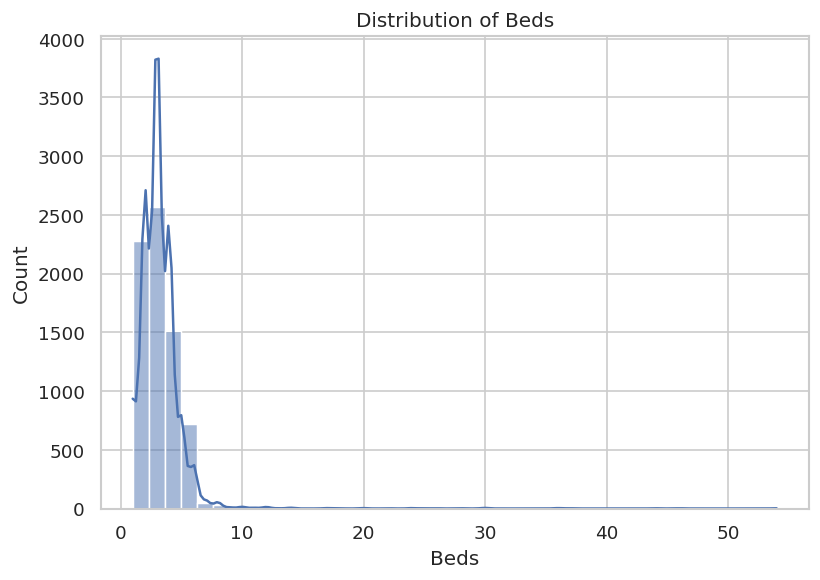

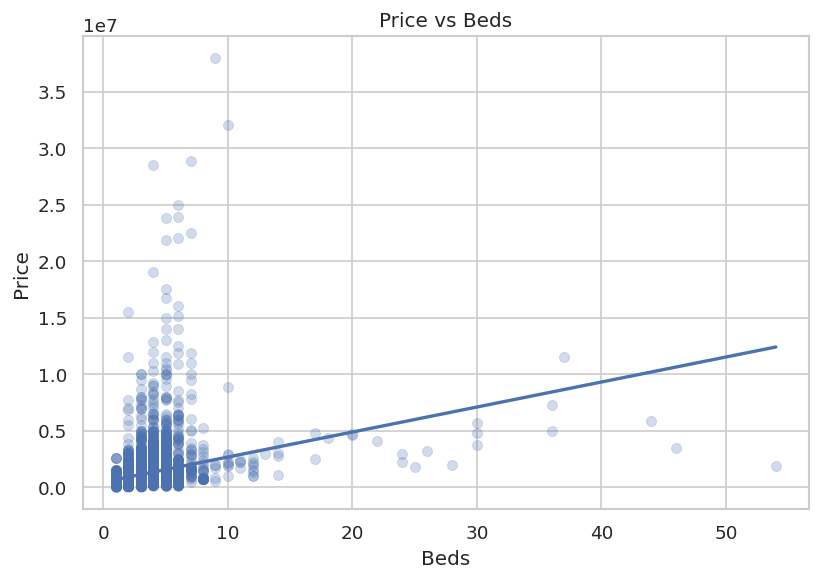

[2/30] Baths


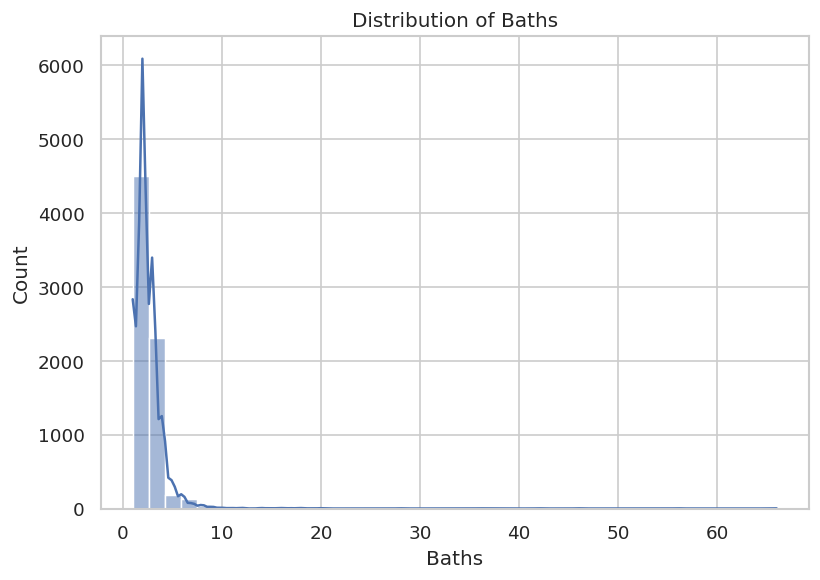

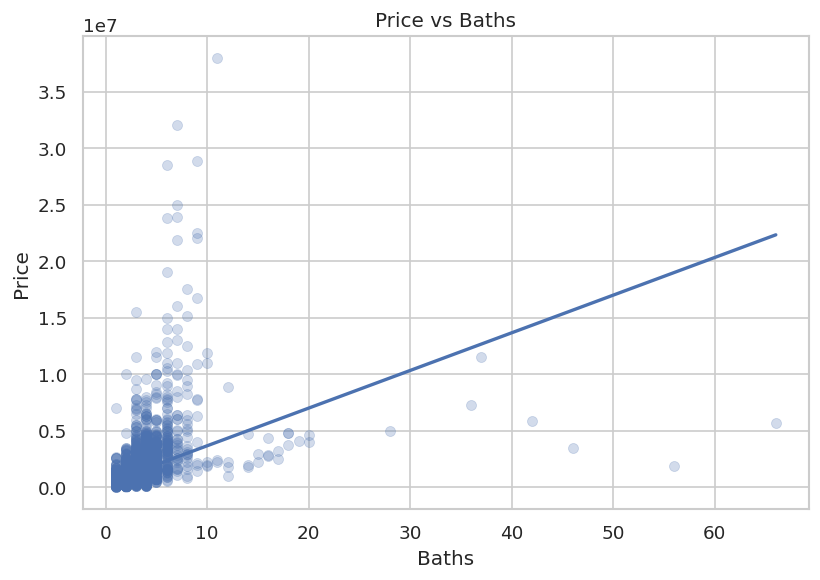

[3/30] Living Space


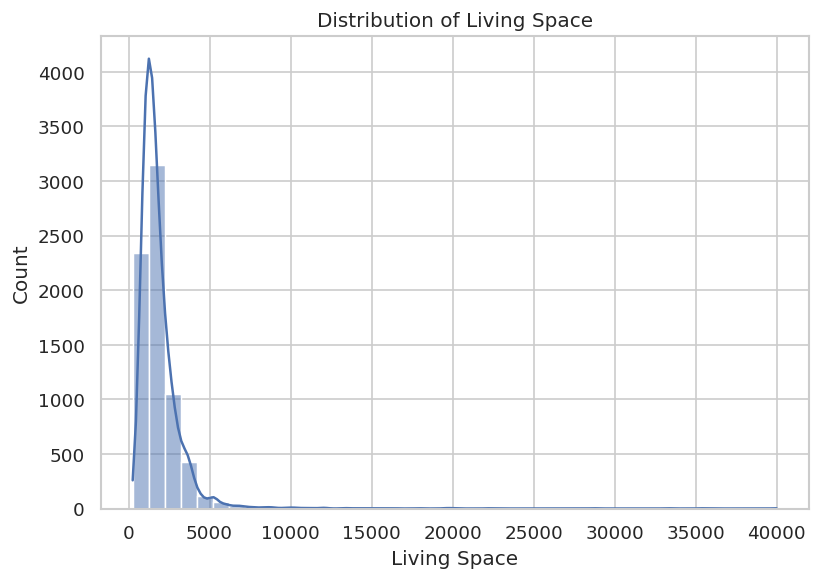

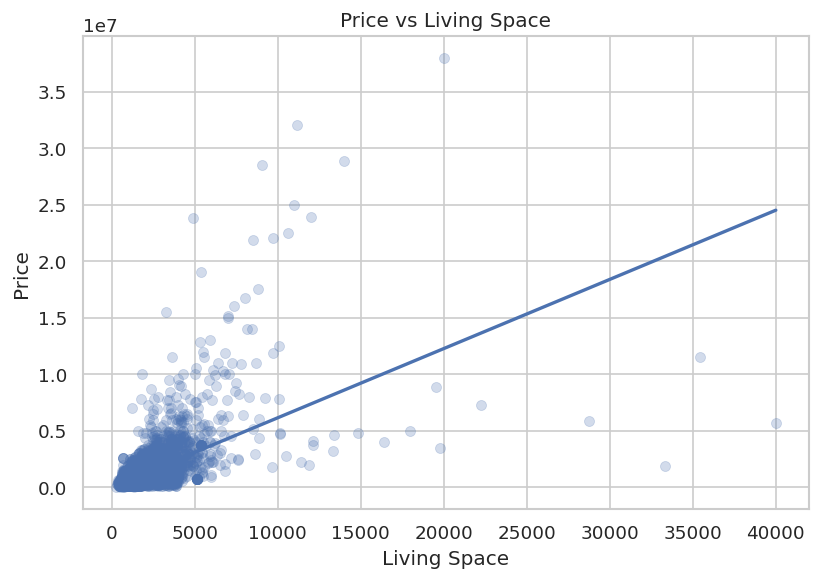

[4/30] City Average Household Income


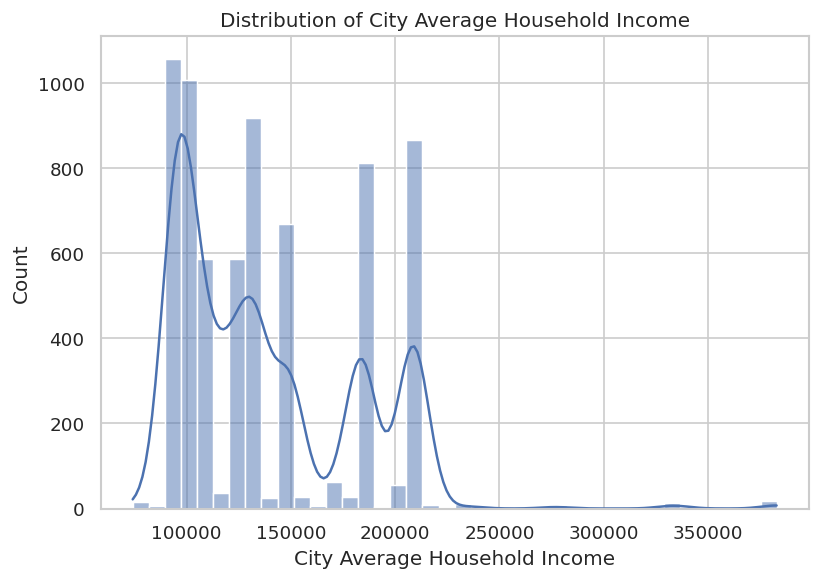

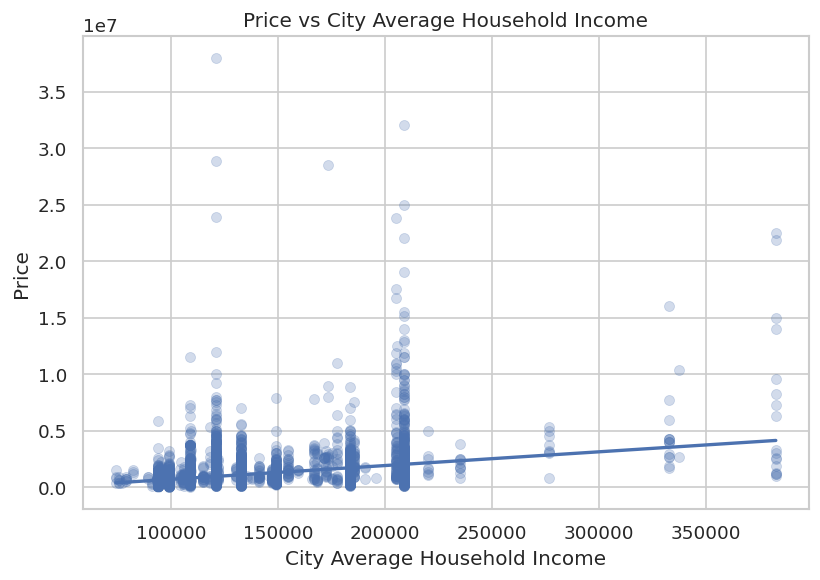

[5/30] Latitude


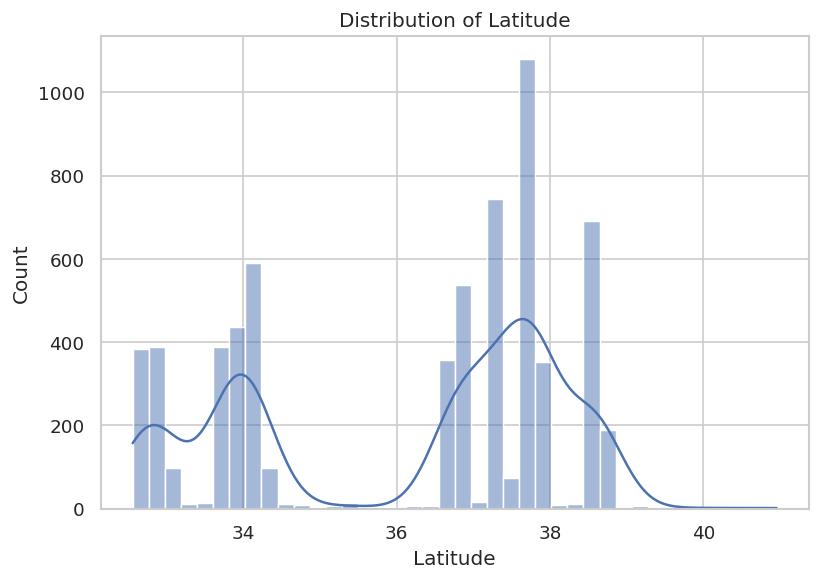

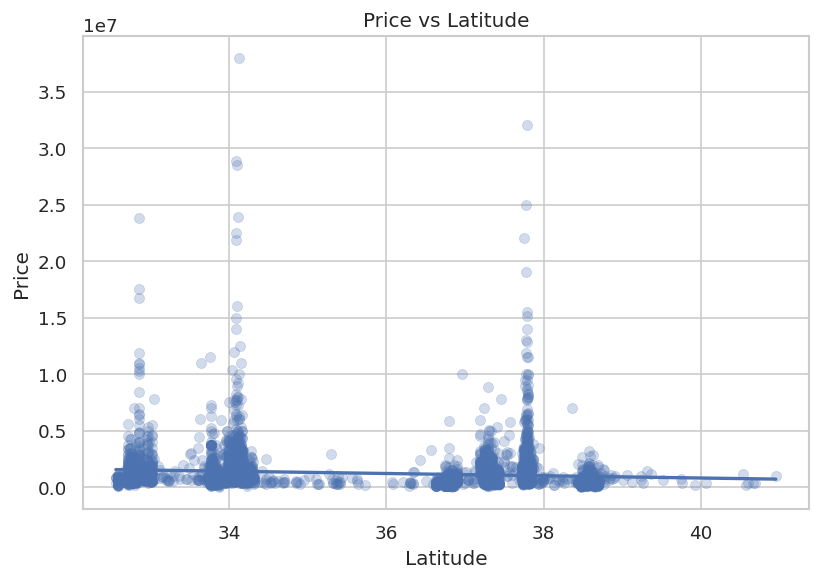

[6/30] Longitude


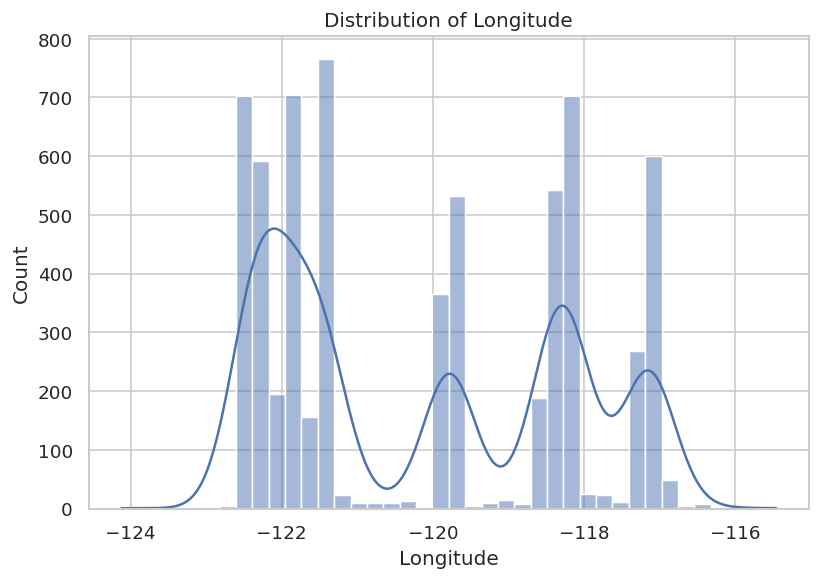

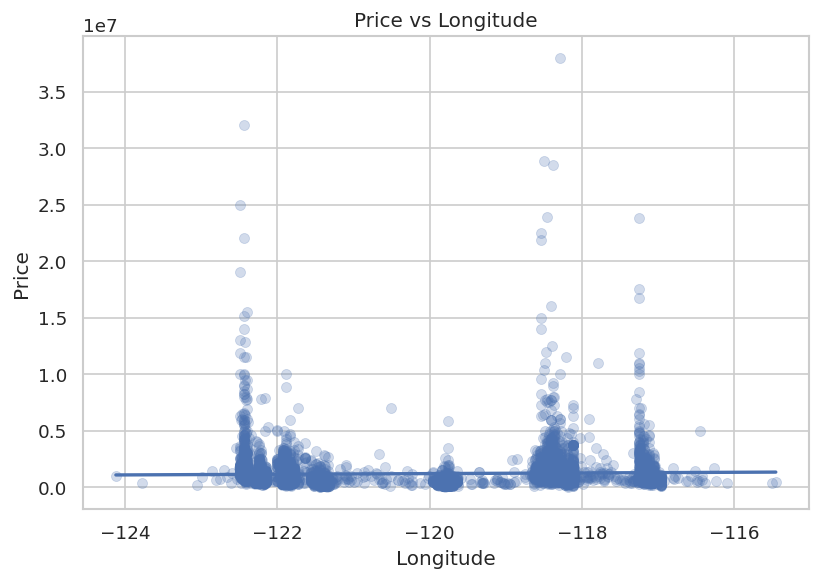

[7/30] Crime Rate


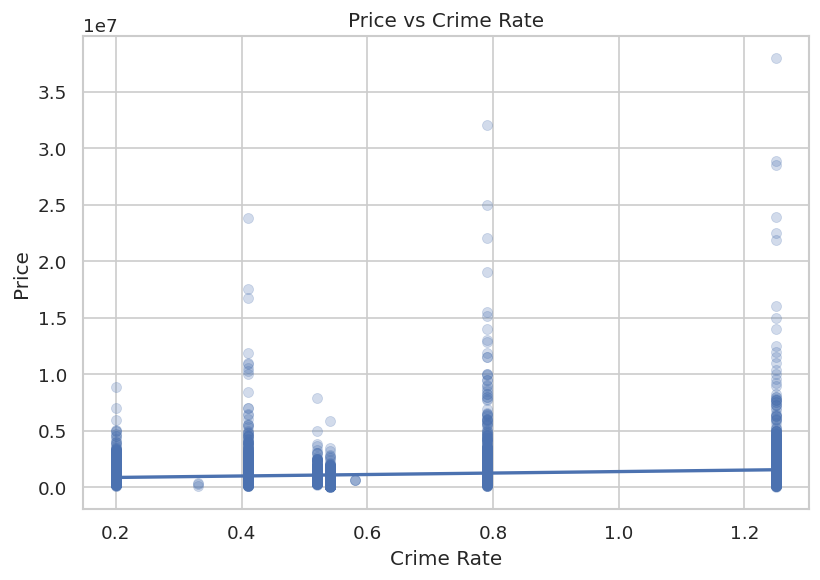

[8/30] percent_bike


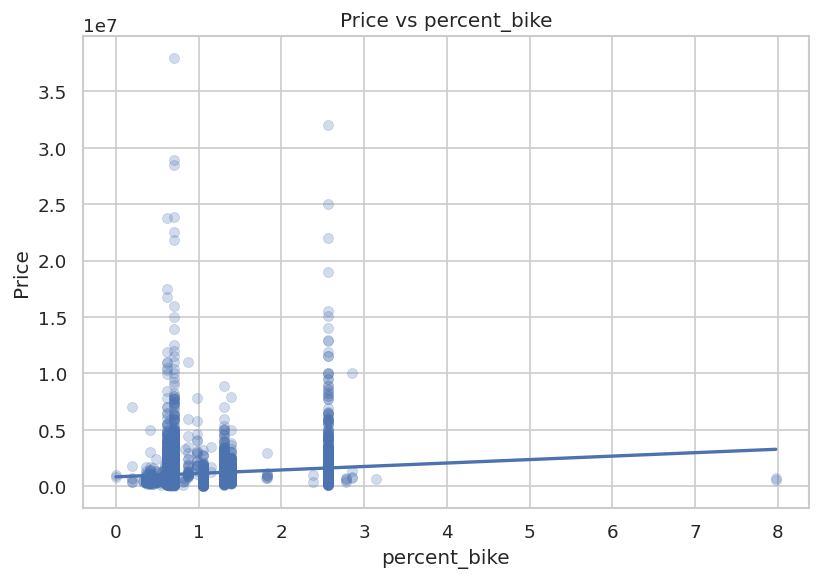

[9/30] percent_car


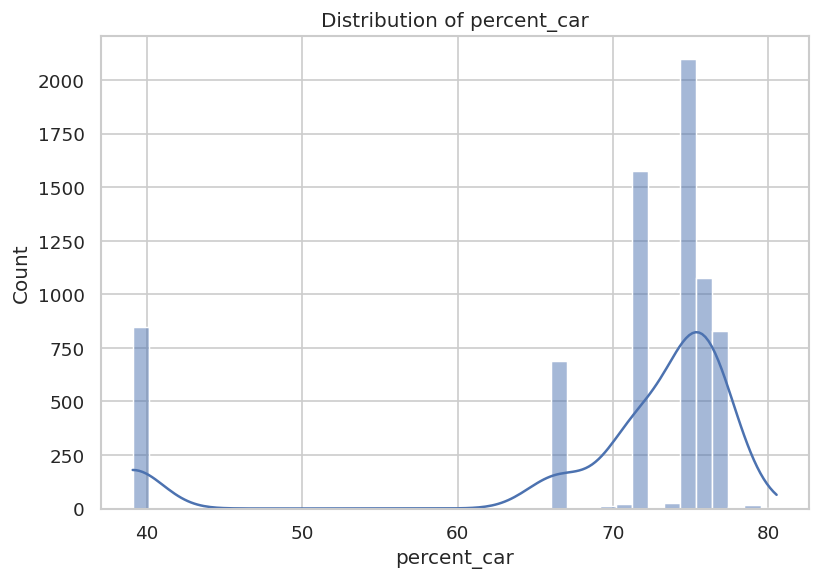

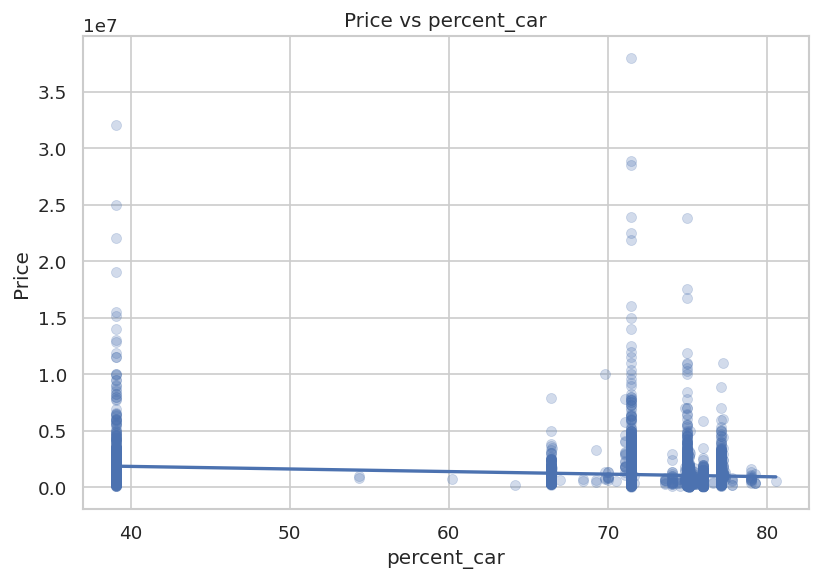

[10/30] percent_carpool


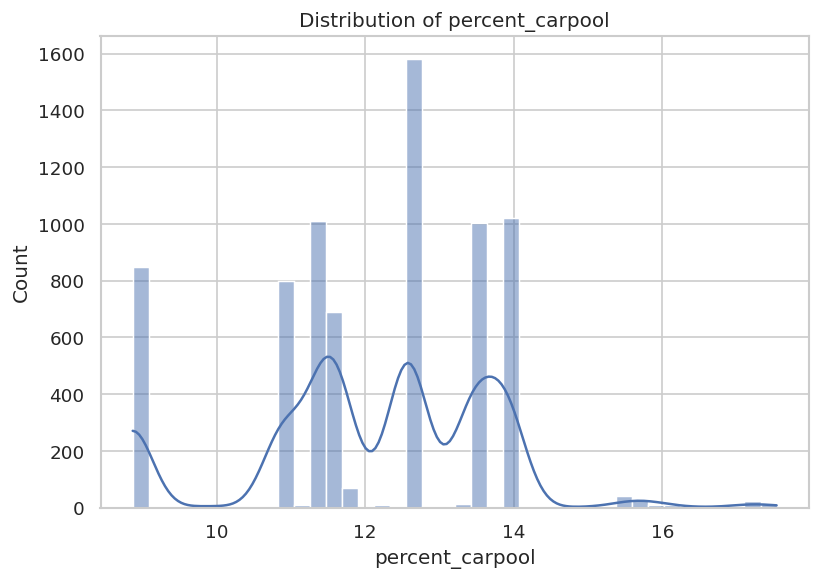

[11/30] percent_home


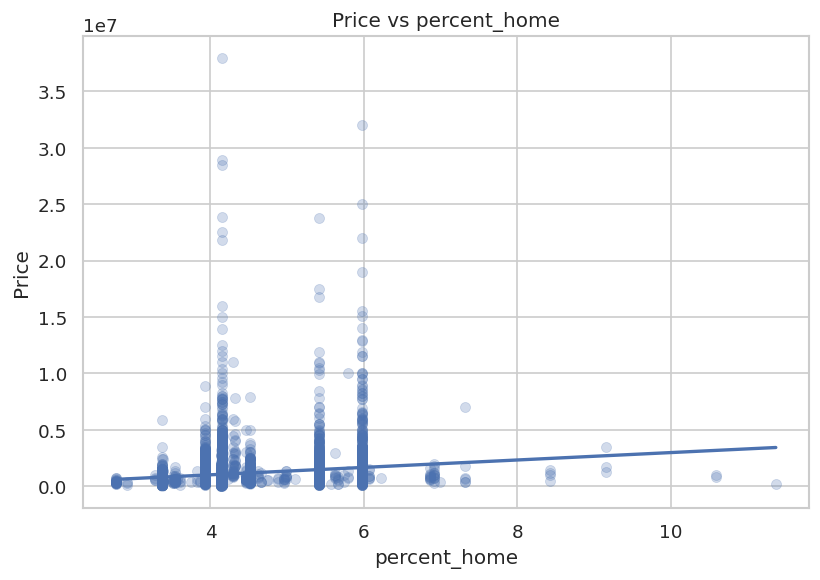

[12/30] percent_publictr


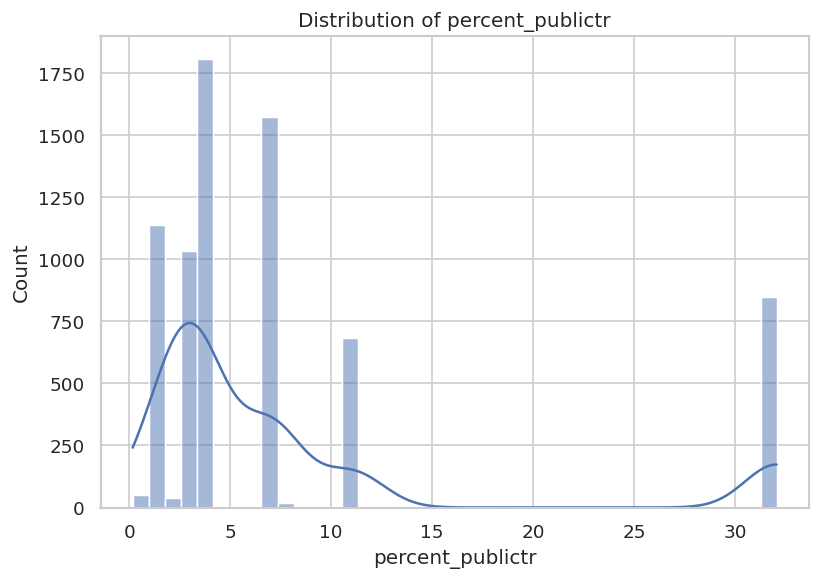

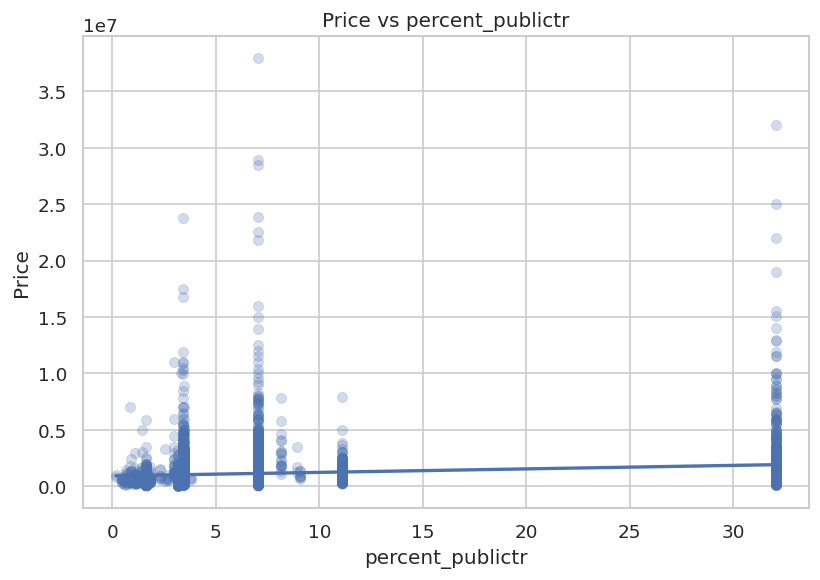

[13/30] percent_total


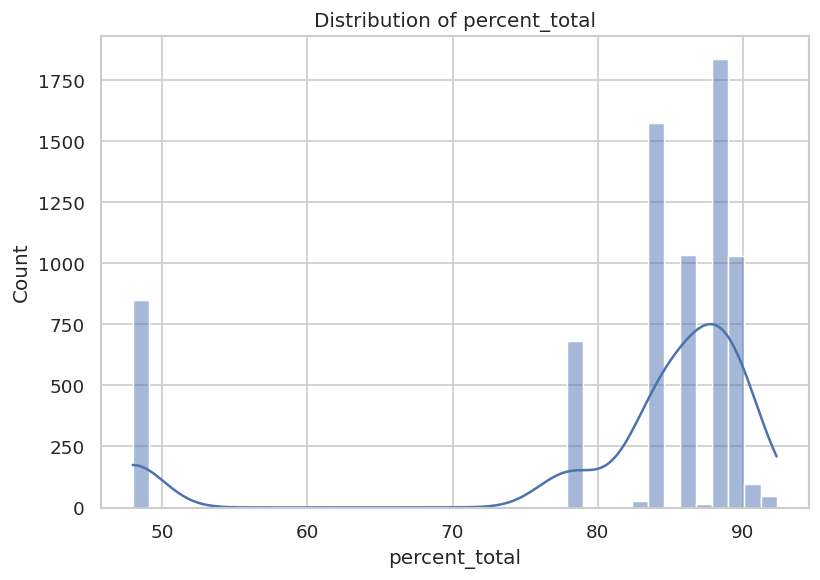

[14/30] percent_walk


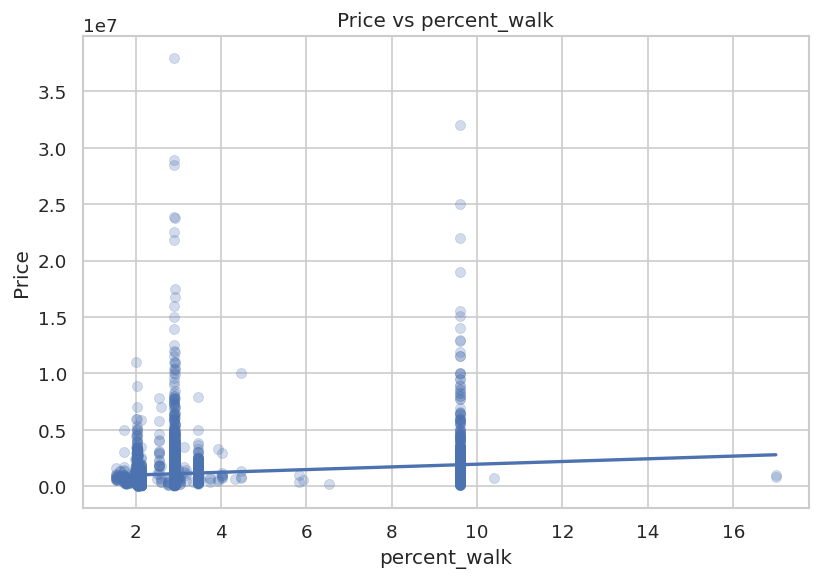

[15/30] Population


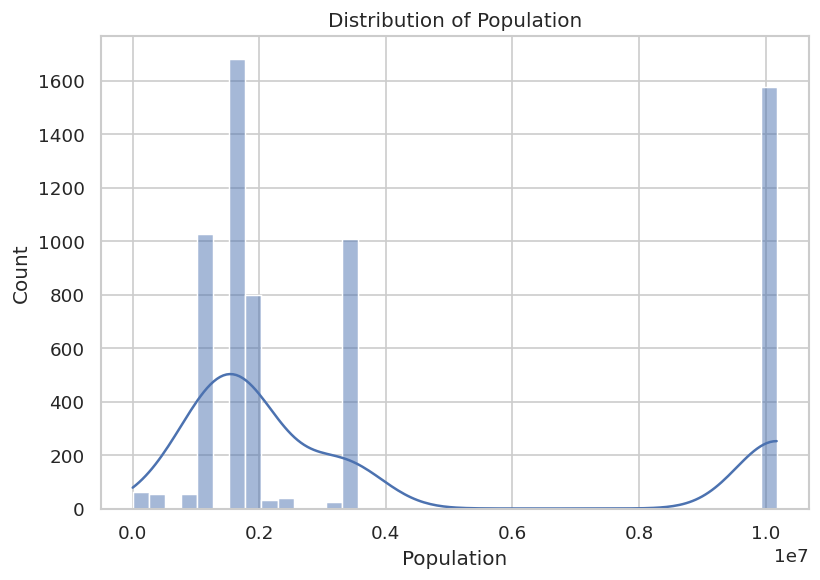

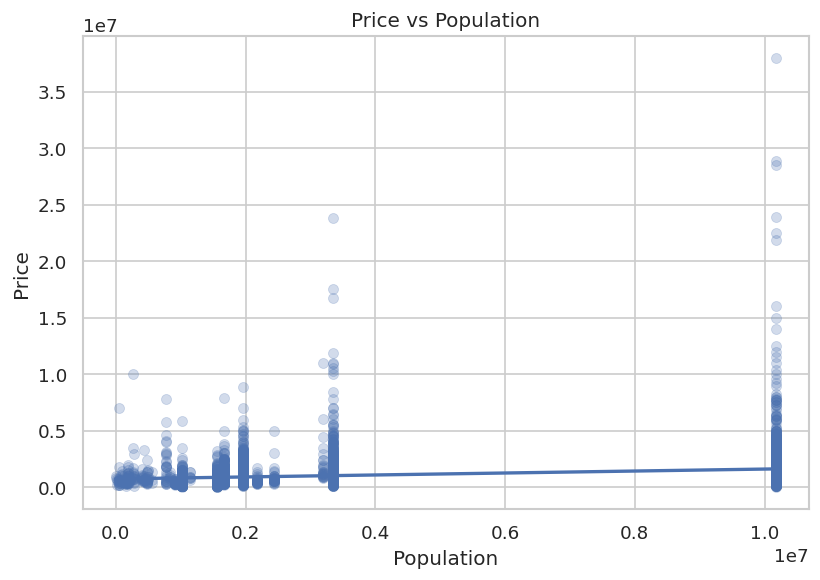

[16/30] num_priv_schools


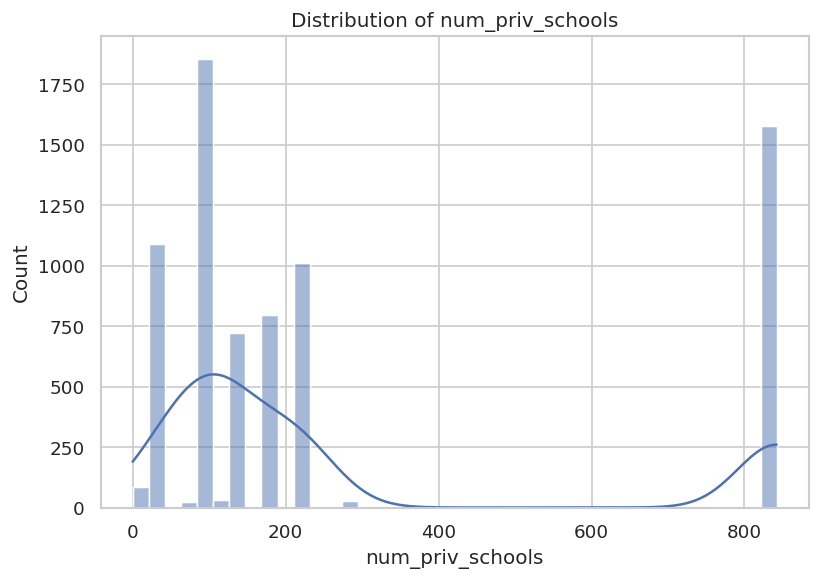

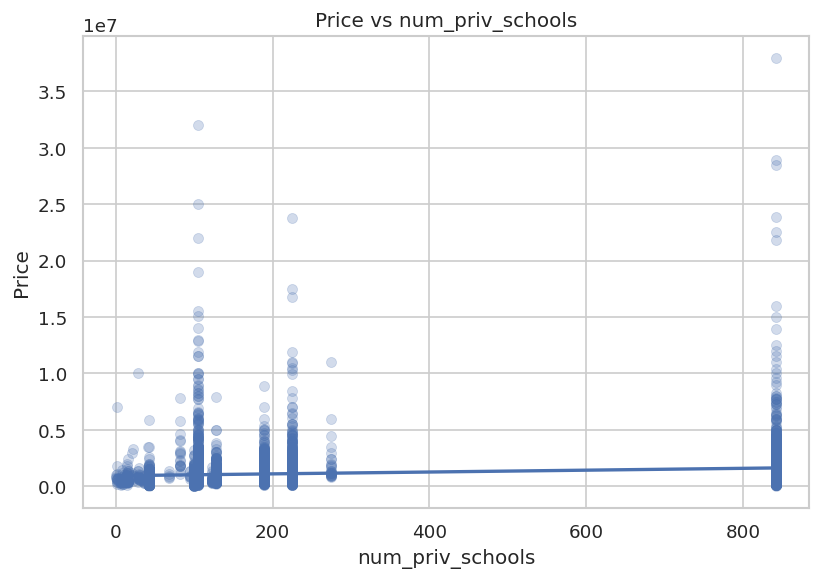

[17/30] Total Enroll


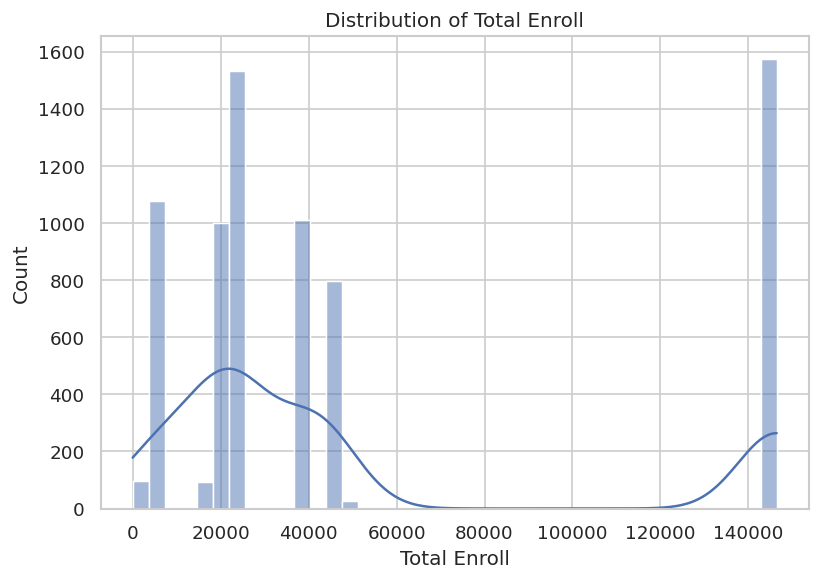

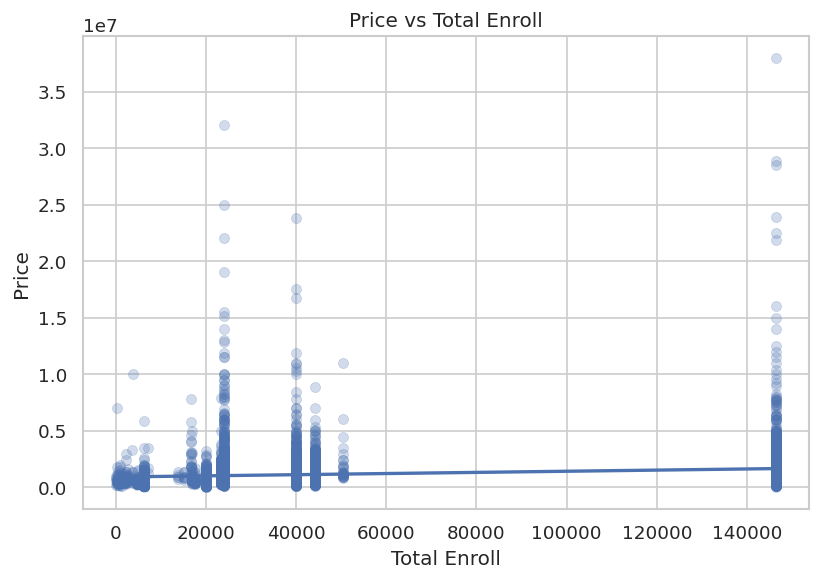

[18/30] K Enroll


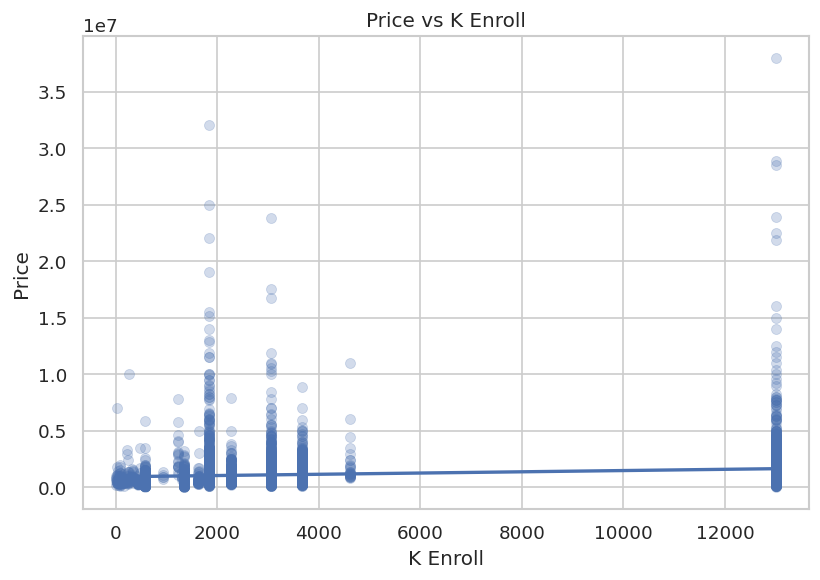

[19/30] G1 Enroll


[20/30] G2 Enroll


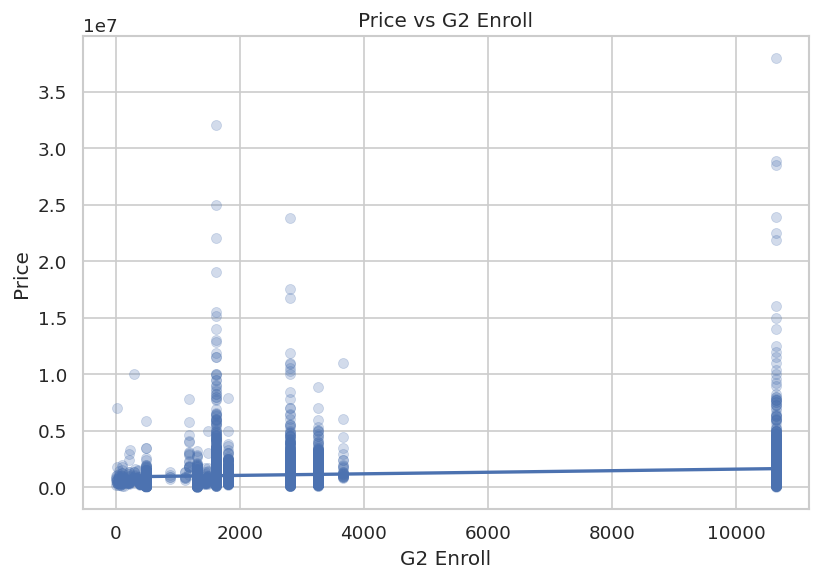

[21/30] G3 Enroll


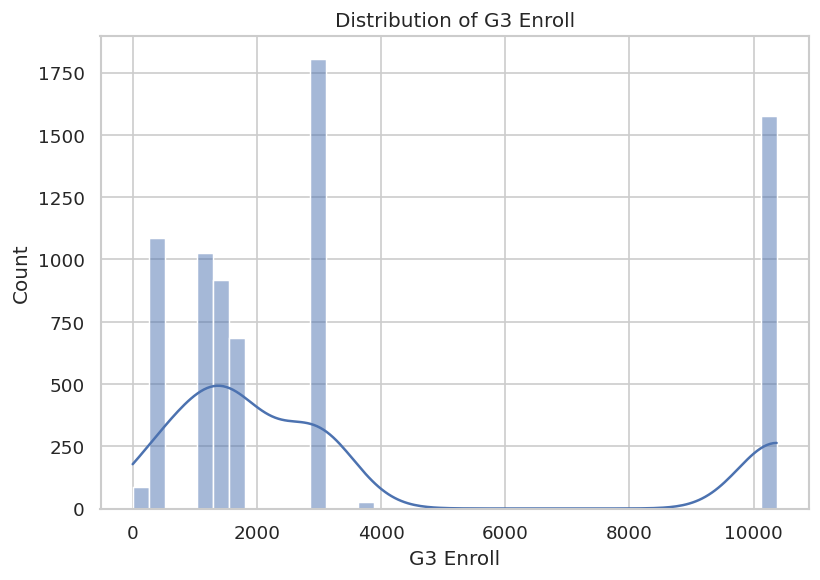

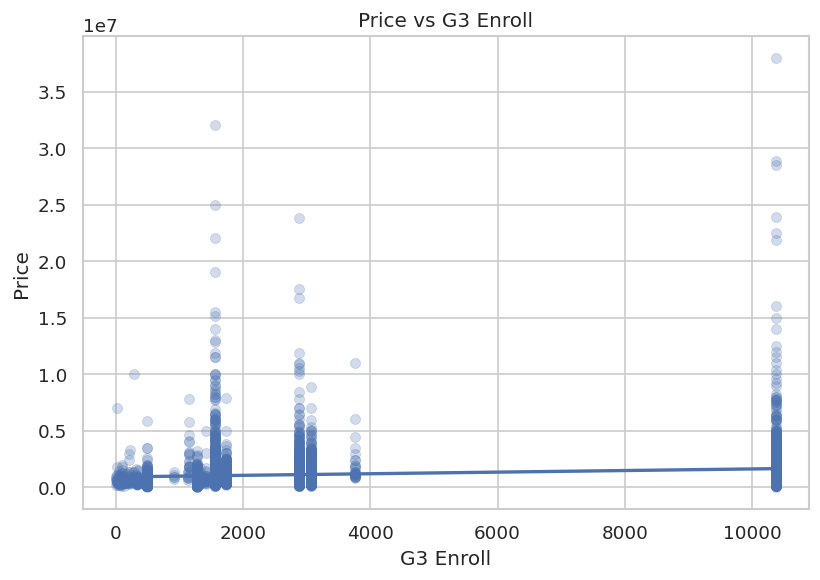

[22/30] G4 Enroll


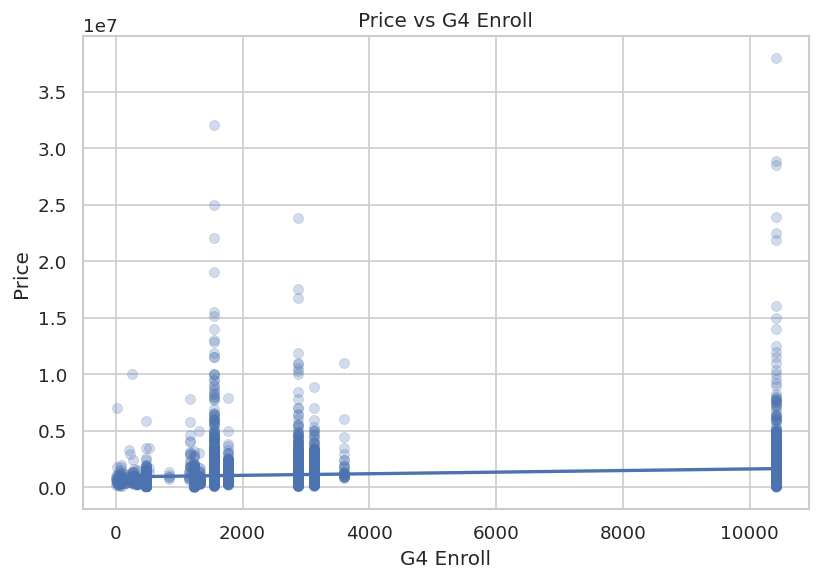

[23/30] G5 Enroll


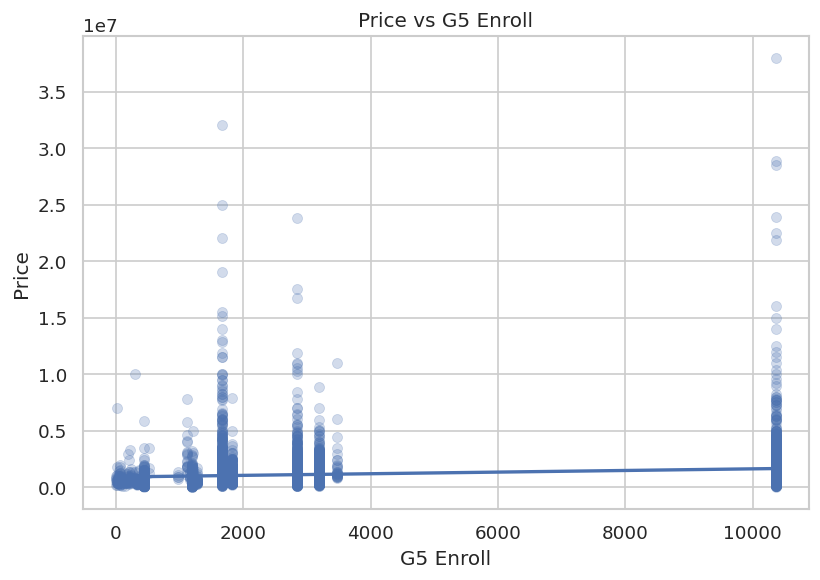

[24/30] G6 Enroll


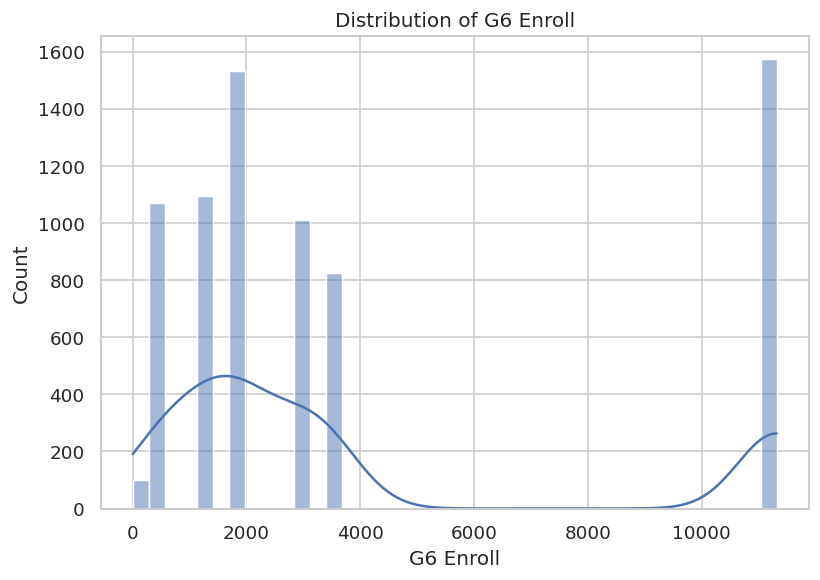

[25/30] G7 Enroll


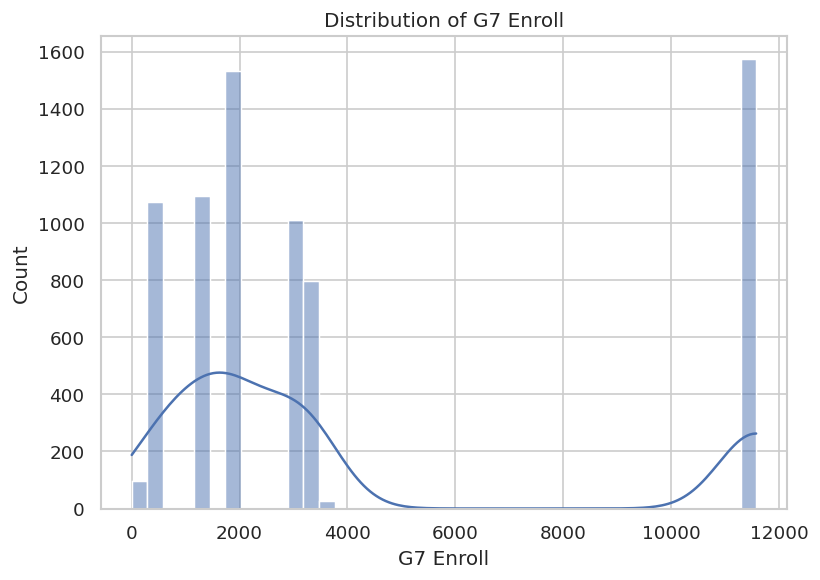

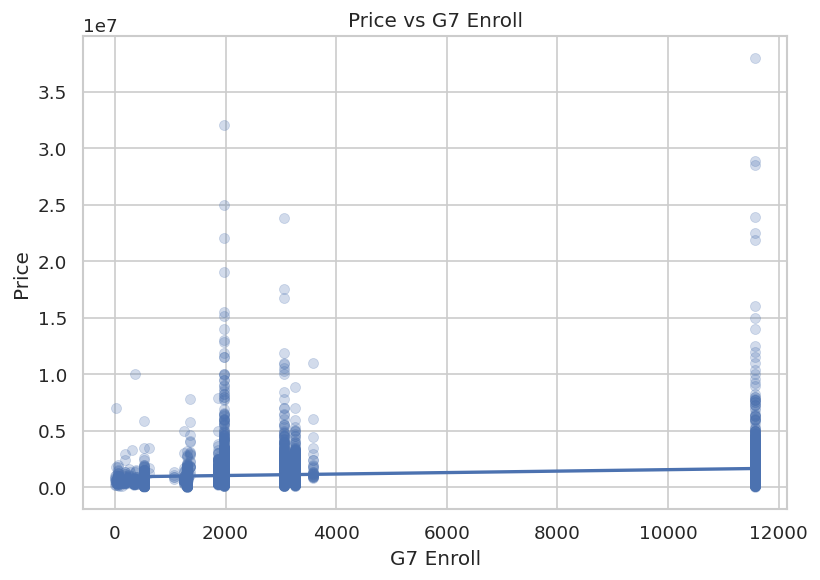

[26/30] G8 Enroll


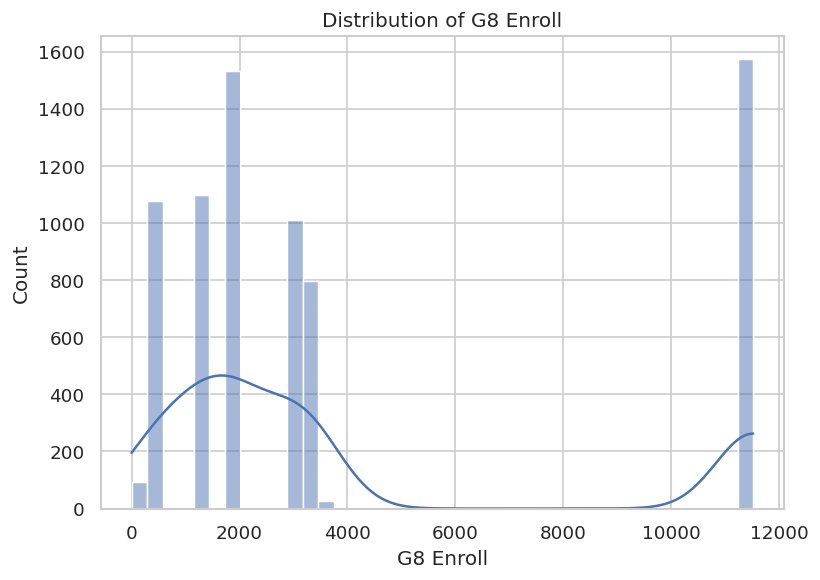

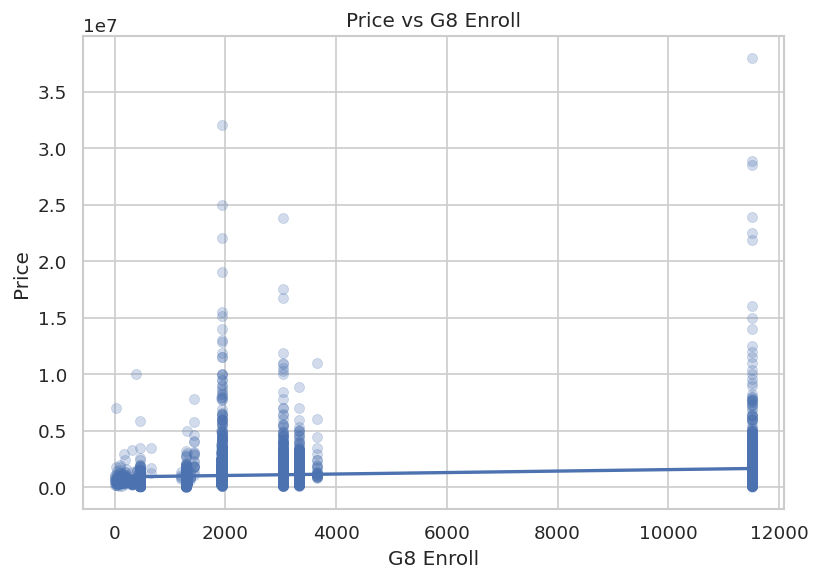

[27/30] G9 Enroll


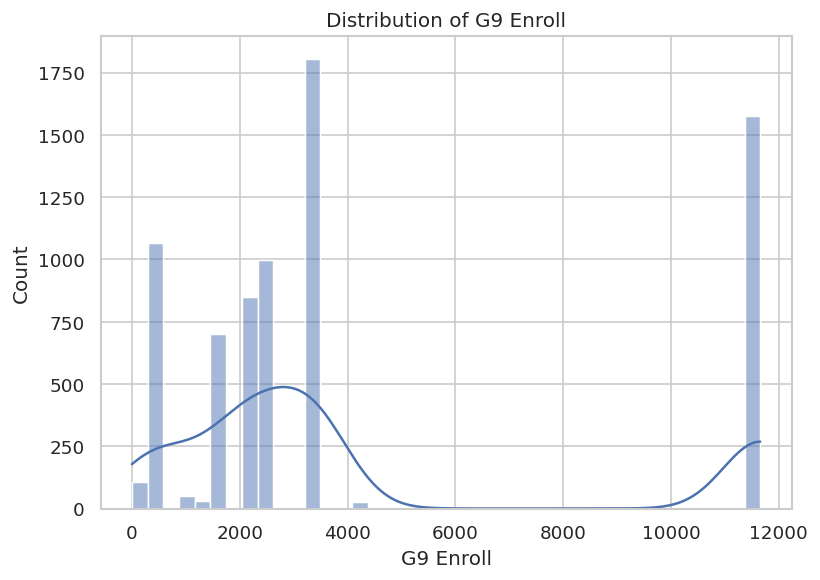

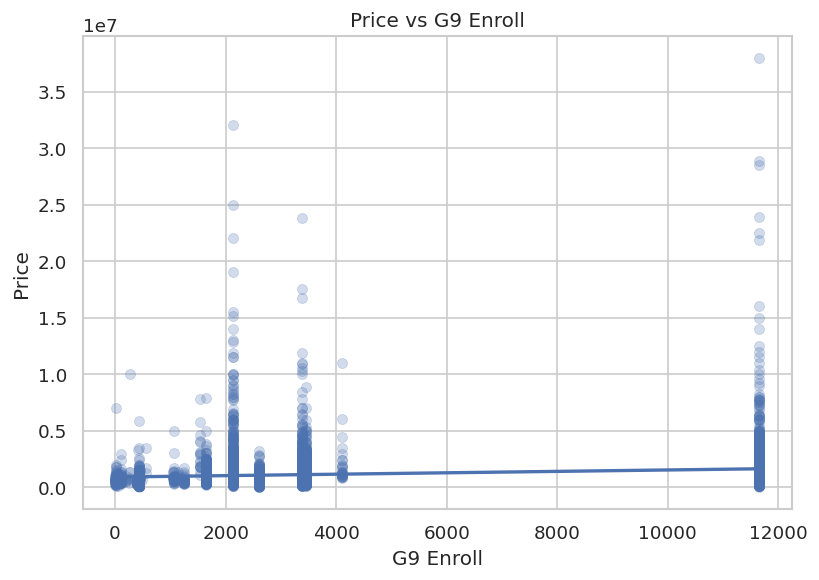

[28/30] G10 Enroll


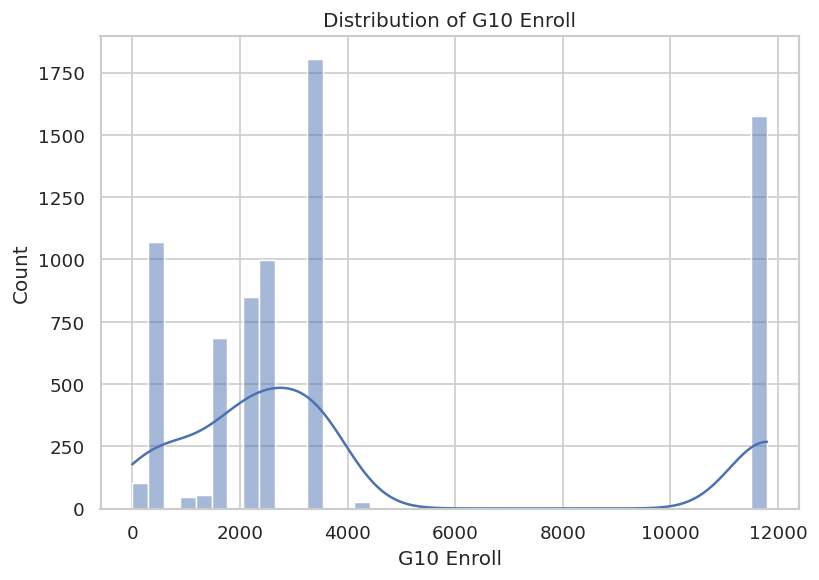

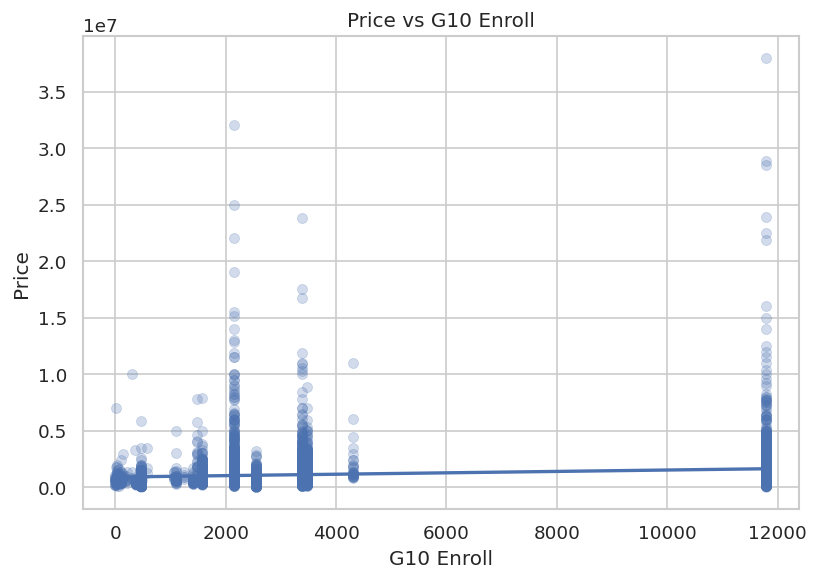

[29/30] G11 Enroll


[30/30] G12 Enroll


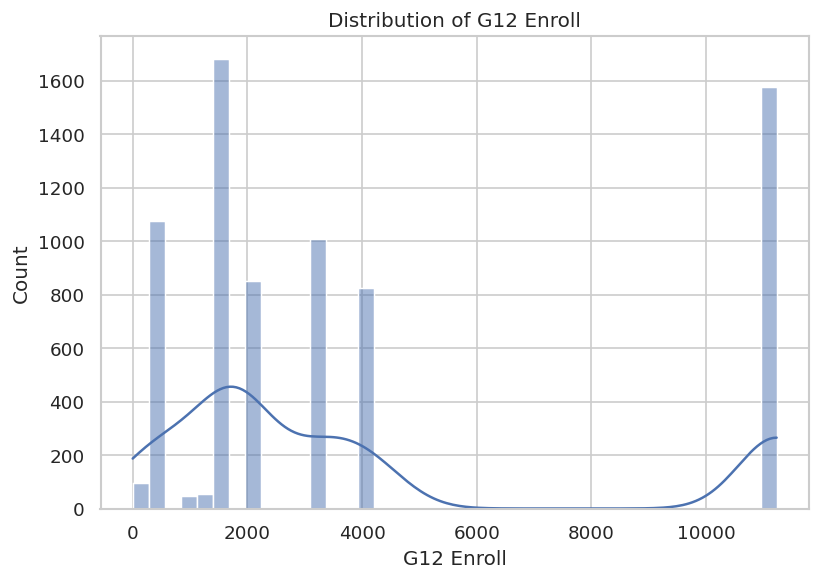

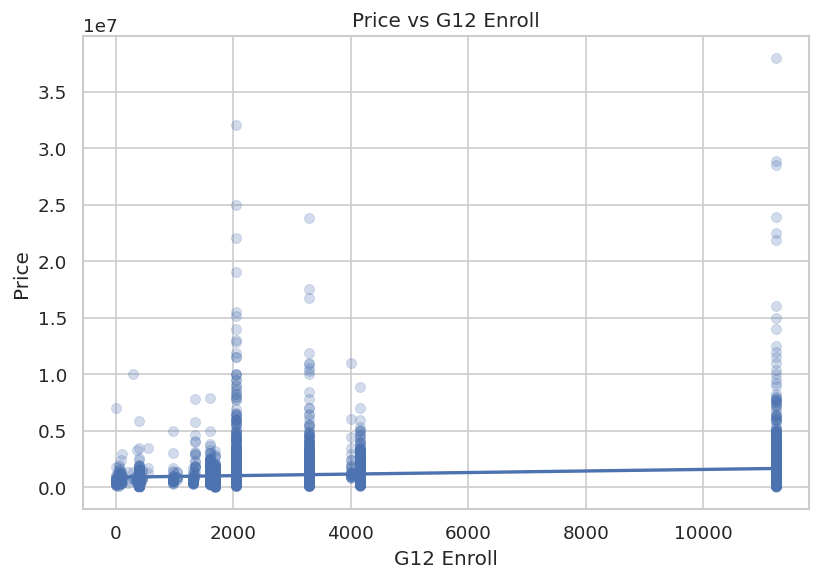


=== Categorical variables (<=30 levels): counts + target boxplot ===
[1/1] State


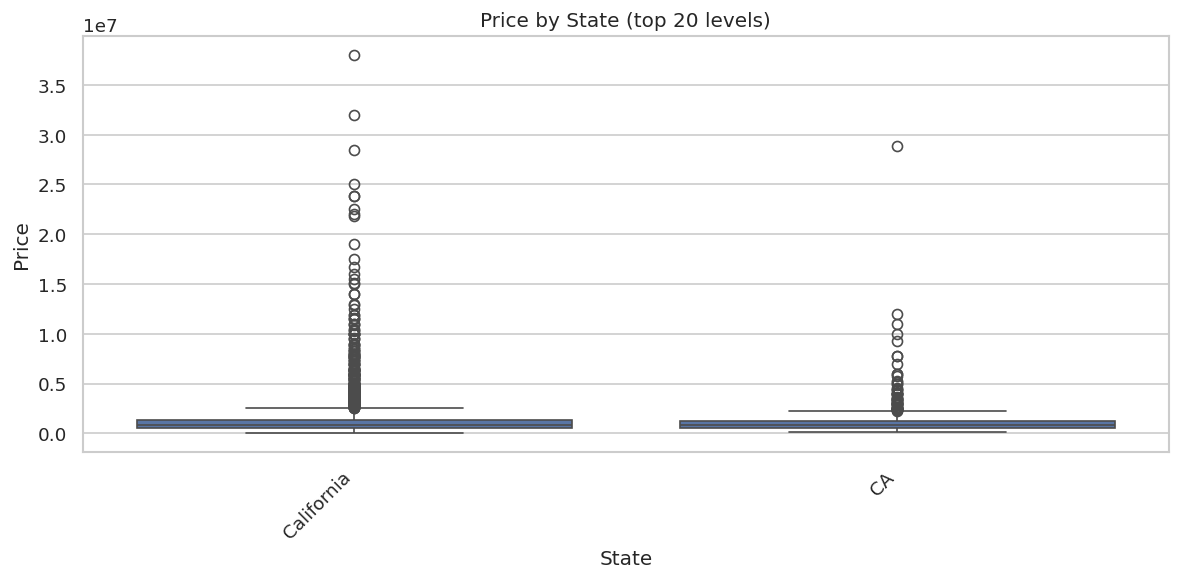

In [ ]:
print("=== Numeric variables: distributions + target scatter ===")
for i, col in enumerate(num_cols, start=1):
    print(f"[{i}/{len(num_cols)}] {col}")
    numeric_distribution(df, col, fname_prefix="num")
    scatter_with_trend(df, col, TARGET, fname_prefix="num")

print("\n=== Categorical variables (<=30 levels): counts + target boxplot ===")
for i, col in enumerate(cat_small, start=1):
    print(f"[{i}/{len(cat_small)}] {col}")
    categorical_countplot(df, col, fname_prefix="cat")
    categorical_box_vs_target(df, col, TARGET, fname_prefix="cat")

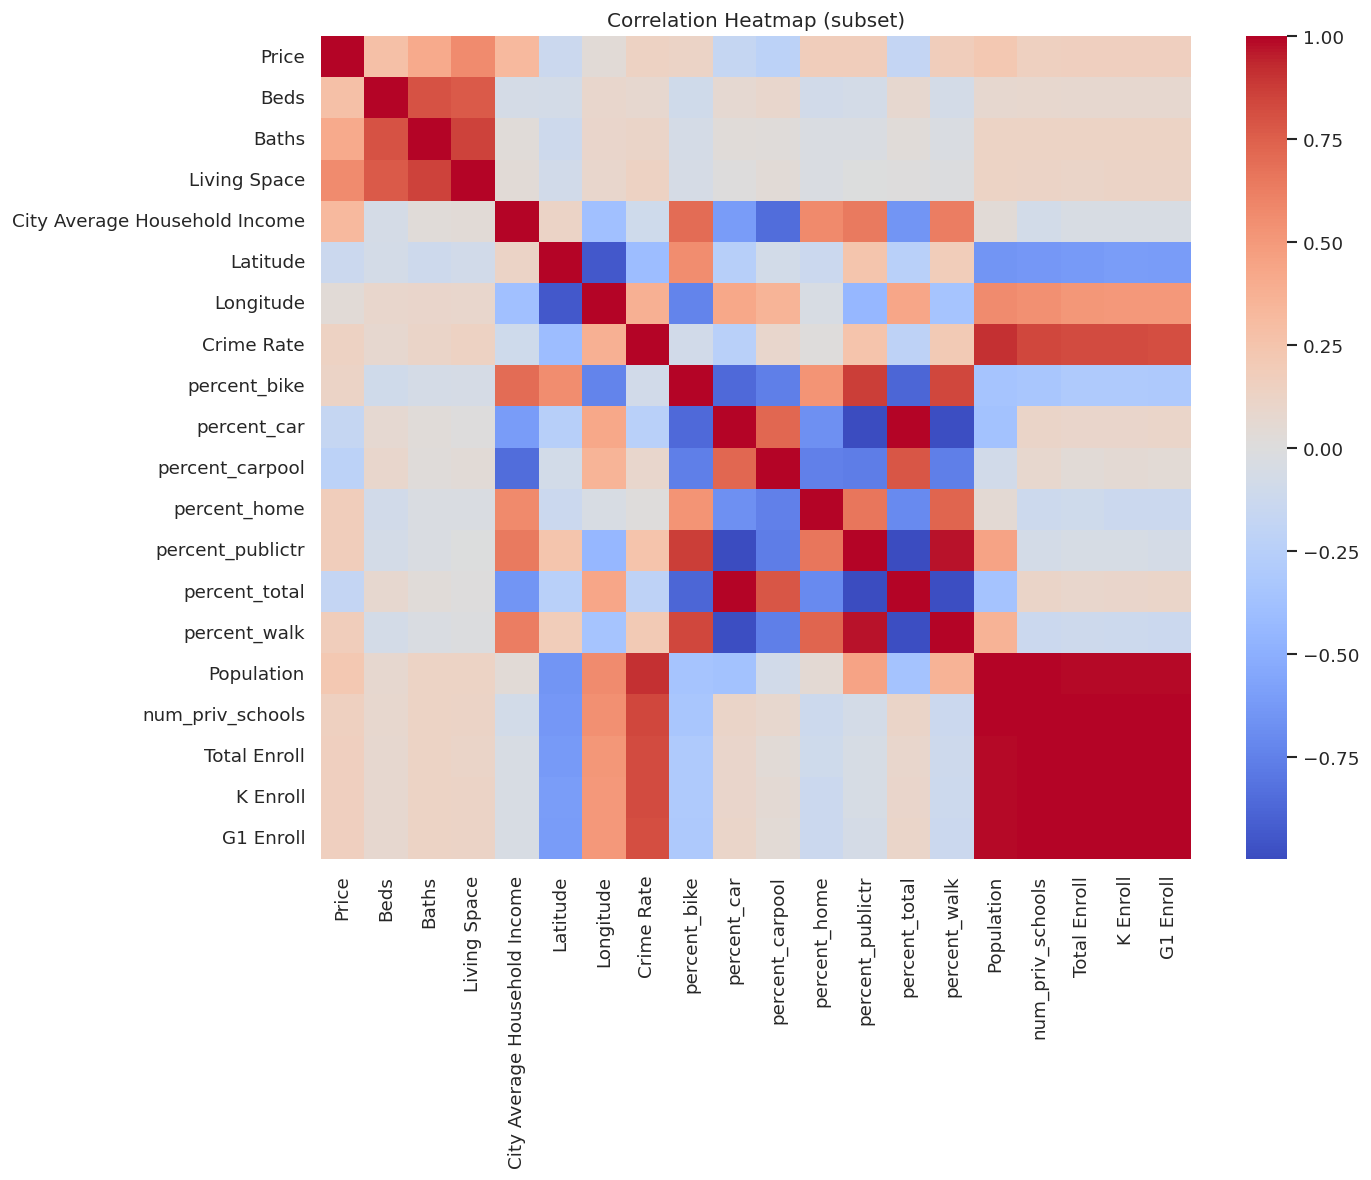

Top correlated with target: ['Living Space', 'Baths', 'City Average Household Income', 'Beds', 'Population']


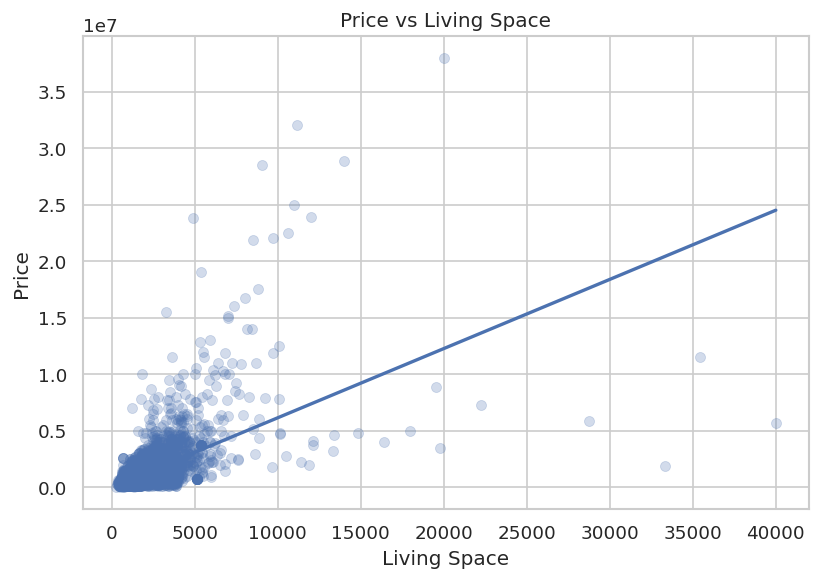

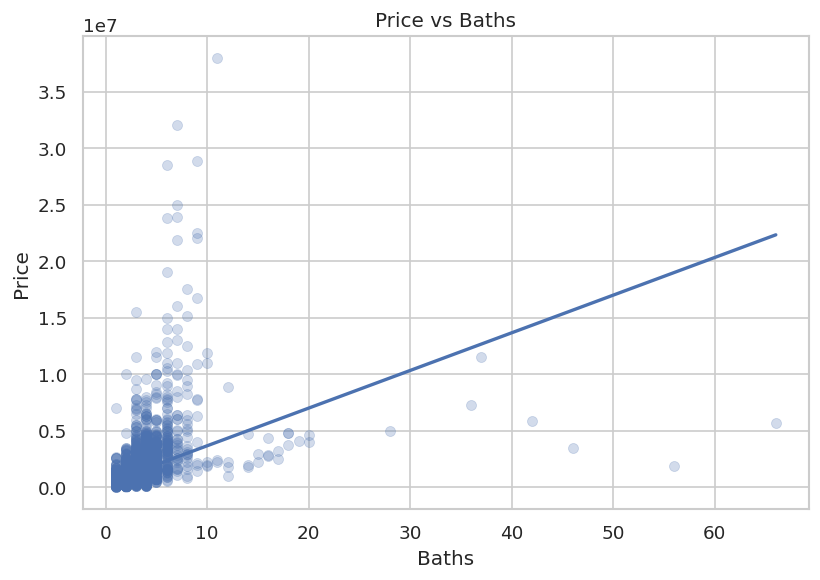

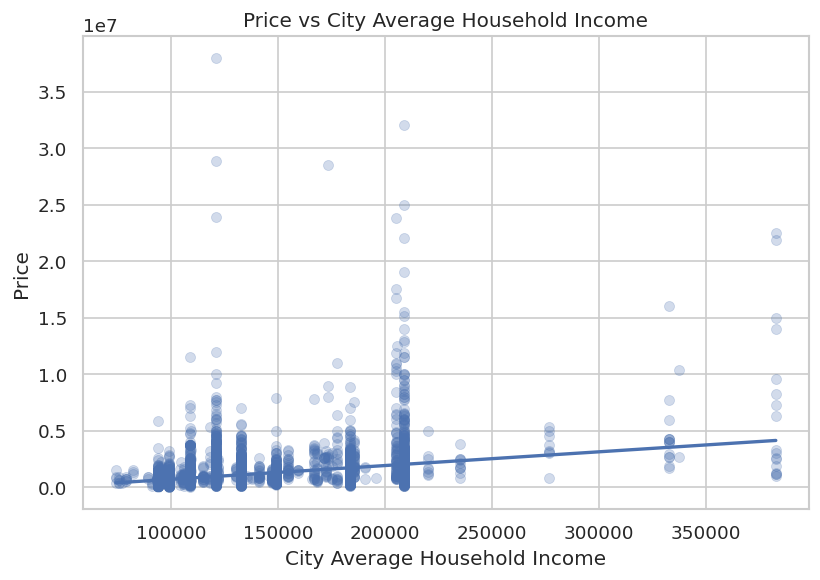

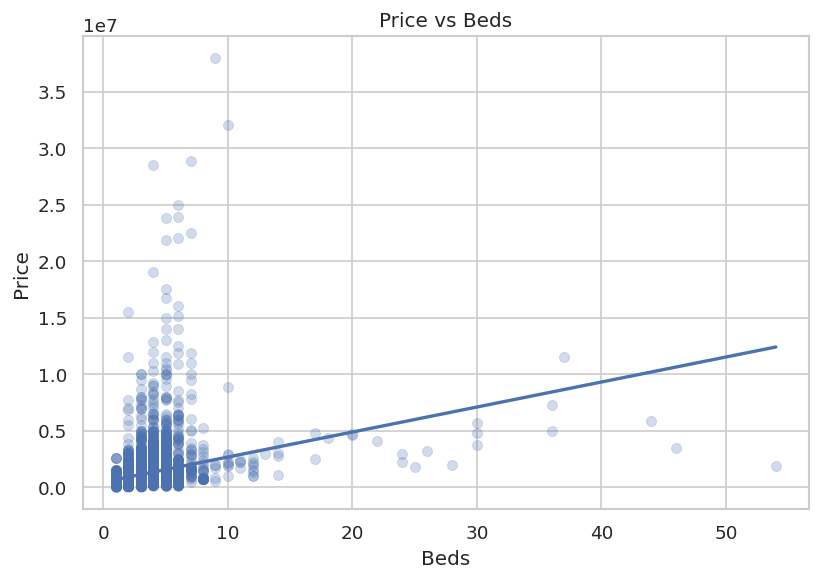

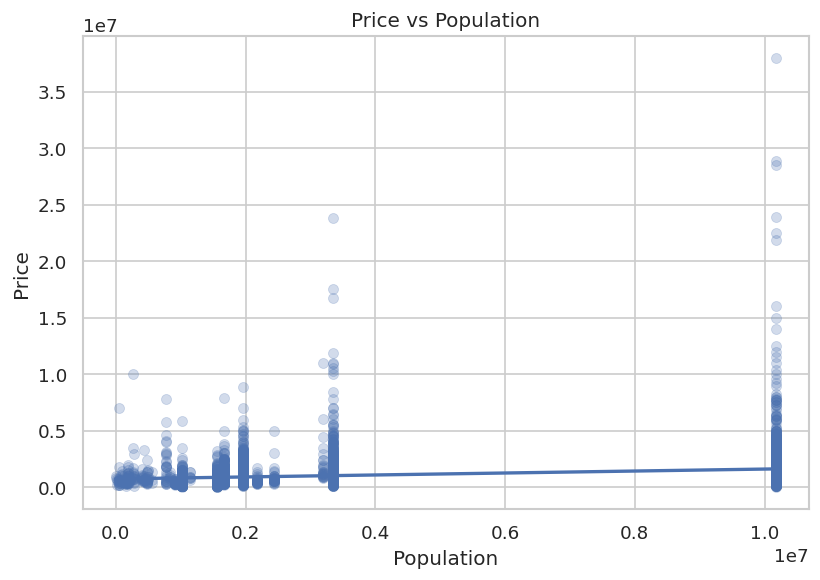

In [ ]:
num_subset = [TARGET] + num_cols
num_subset = num_subset[:20]
corr = df[num_subset].corr(numeric_only=True)

plt.figure(figsize=(min(12, 0.6*len(num_subset)+4), min(10, 0.6*len(num_subset)+4)))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (subset)")
plt.tight_layout()
plt.savefig("/content/plots/correlation_heatmap_subset.png")
plt.show()

corr_to_target = corr[TARGET].drop(TARGET).abs().sort_values(ascending=False)
topk = corr_to_target.head(5).index.tolist()
print("Top correlated with target:", topk)

for col in topk:
    scatter_with_trend(df, col, TARGET, fname_prefix="topcorr")

In [ ]:
df["log_Price"] = np.log1p(df["Price"])
sns.histplot(df["log_Price"], kde=True, bins=40)
plt.title("Distribution of log(Price)")
plt.show()

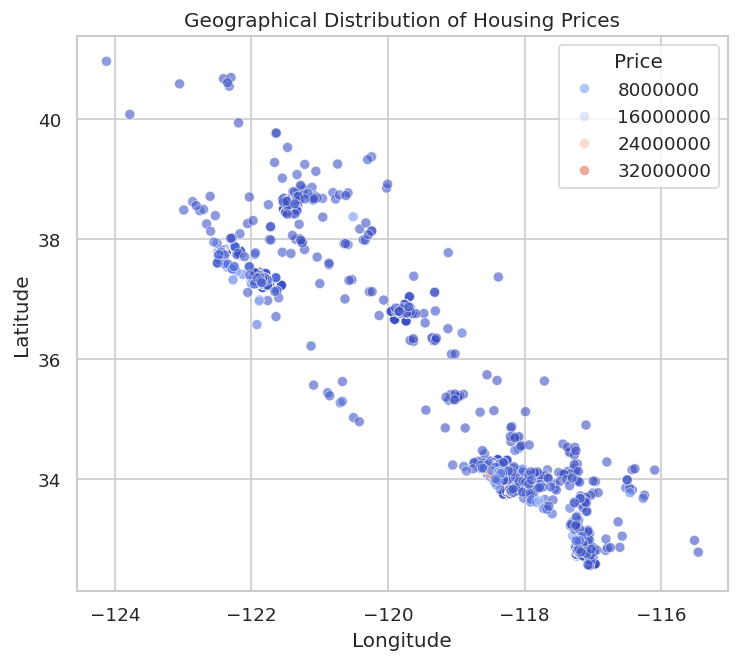

In [ ]:
plt.figure(figsize=(7,6))
sns.scatterplot(data=df, x="Longitude", y="Latitude", hue="Price", palette="coolwarm", alpha=0.6)
plt.title("Geographical Distribution of Housing Prices")
plt.show()

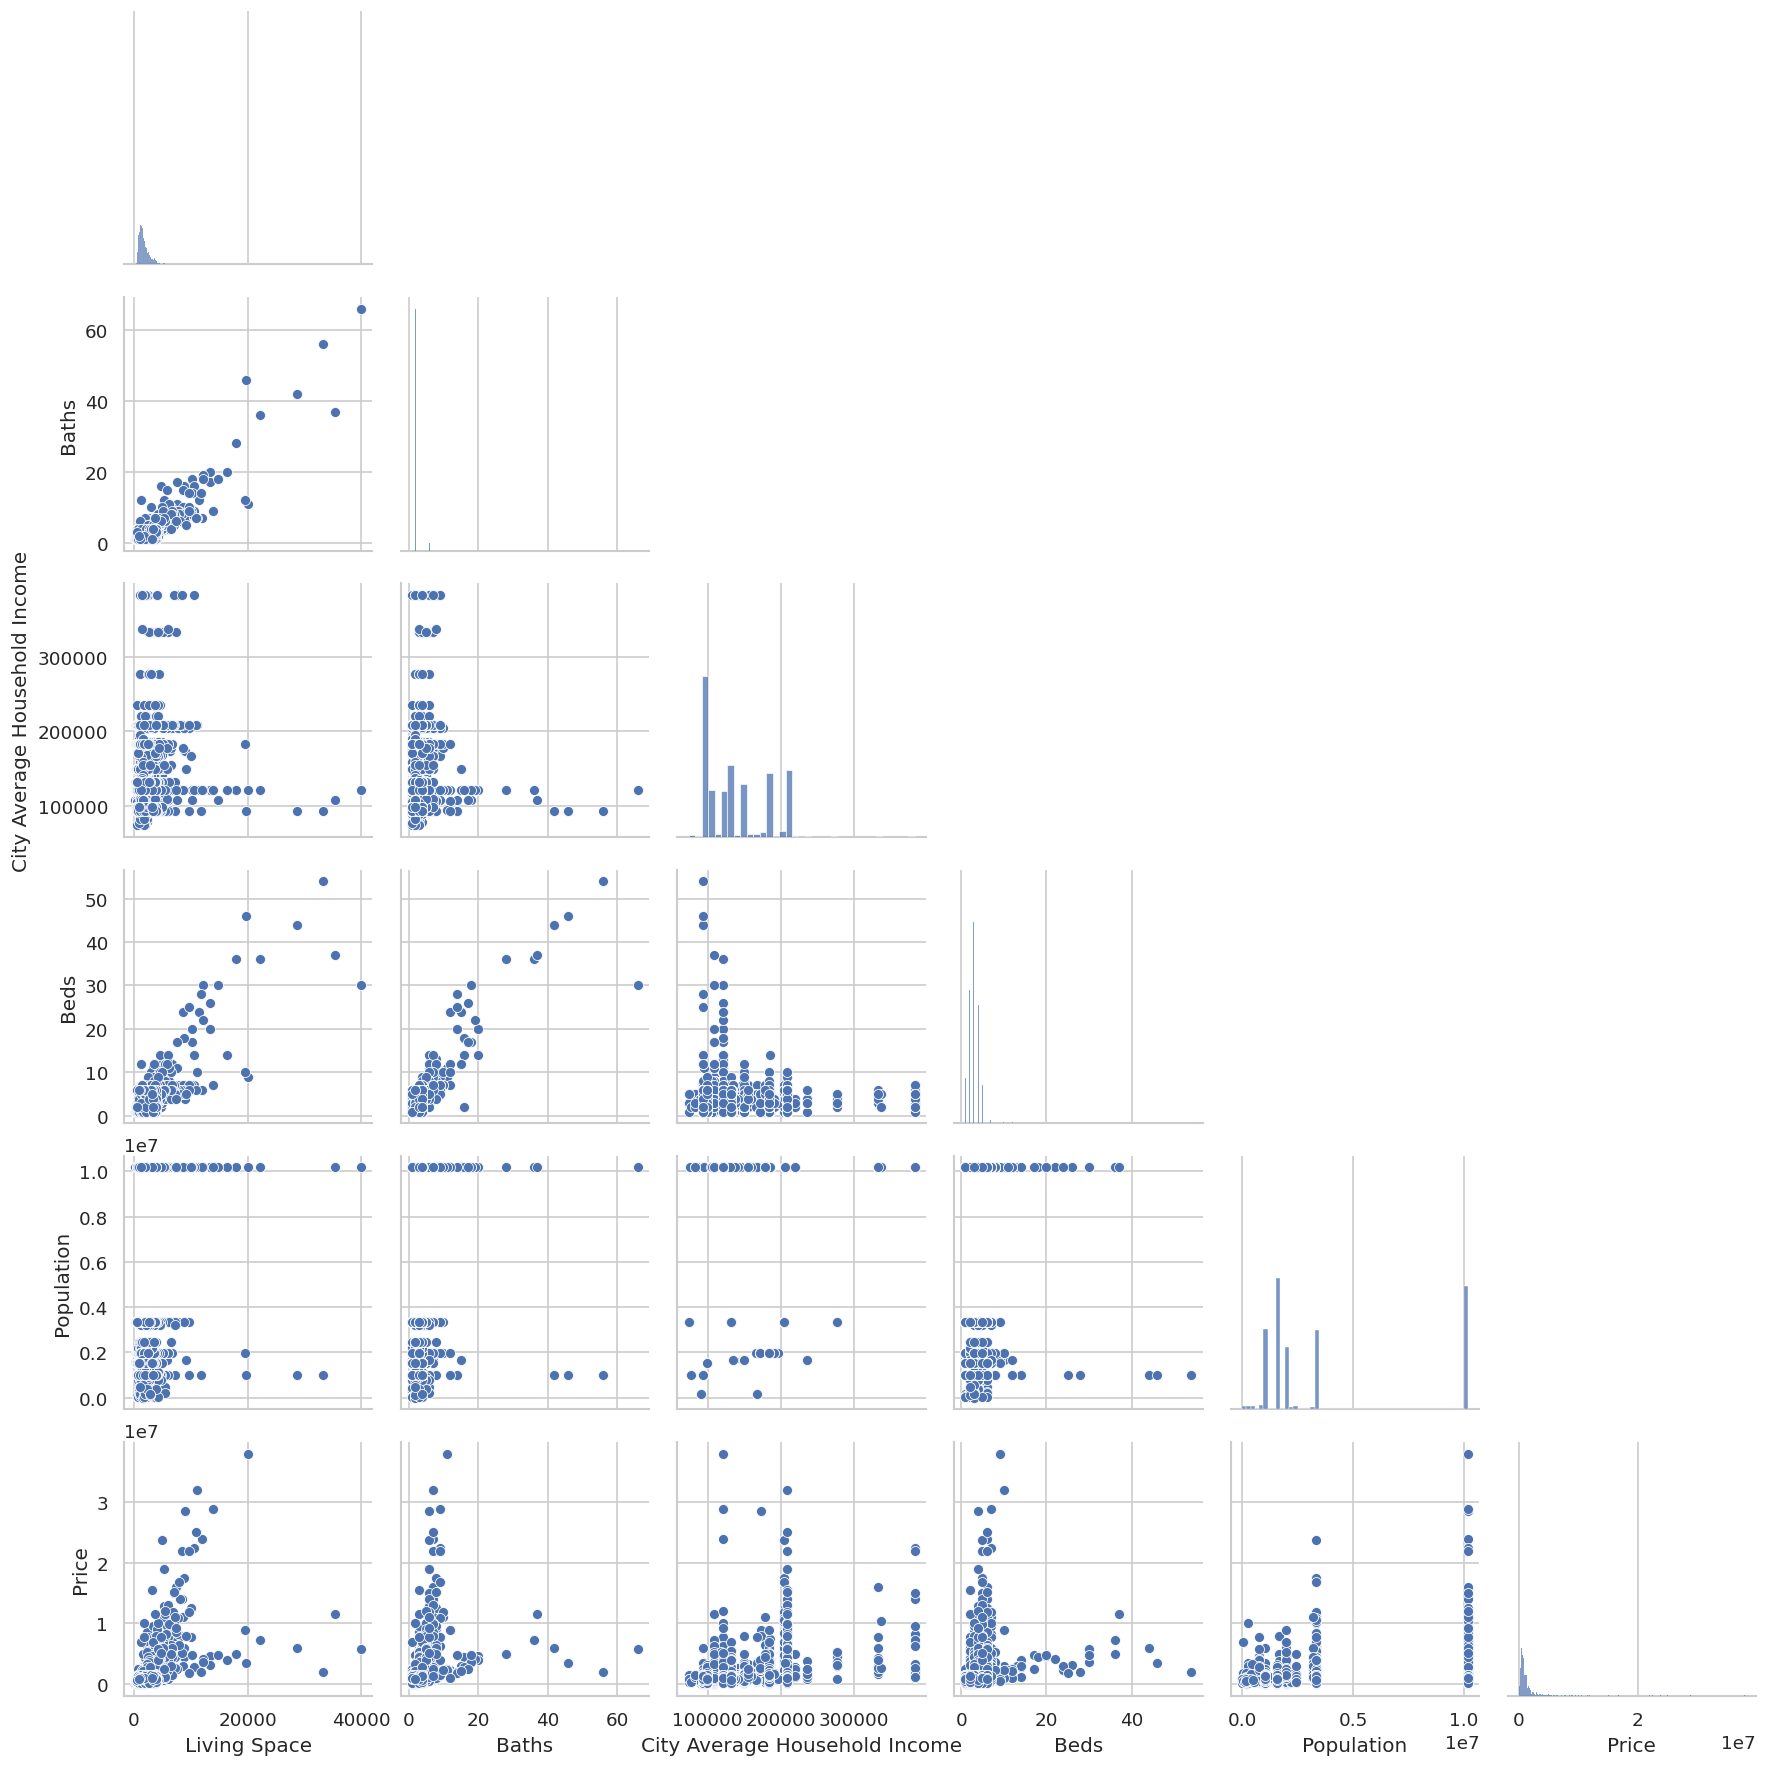

In [ ]:
top_corr = corr_to_target.head(5).index.tolist()
sns.pairplot(df[top_corr + [TARGET]], corner=True)
plt.show()

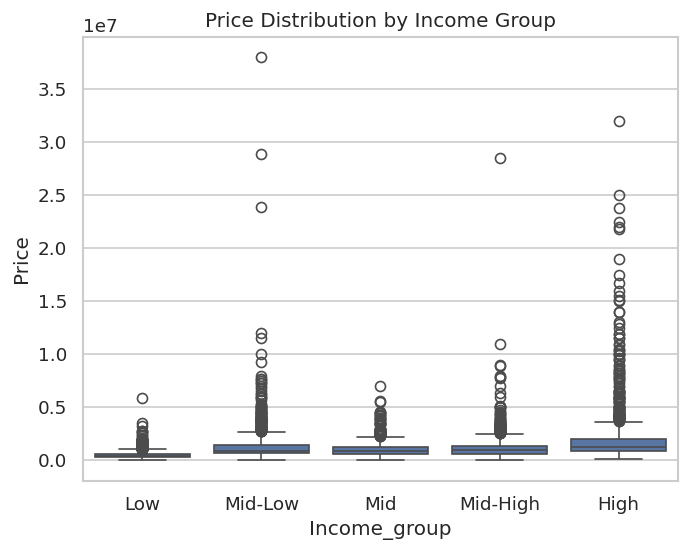

In [ ]:
df["Income_group"] = pd.qcut(df["City Average Household Income"], q=5, labels=["Low","Mid-Low","Mid","Mid-High","High"])
sns.boxplot(x="Income_group", y="Price", data=df)
plt.title("Price Distribution by Income Group")
plt.show()

In [ ]:
import shutil
shutil.make_archive("/content/plots_all", "zip", "/content/plots")

'/content/plots_all.zip'

In [ ]:
from google.colab import files
files.download("/content/plots_all.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>